In [6]:
"""
OBJETIVO : Seleccionar una muestra de datos para el entrenamiento. Este proceso se realiza por cada 
            modelo (Regresion y clasifiacion). Ademas, se realiza una limpieza de datos, y se divide
            el DS para lso modelos de clasifiacion, para asi balancear las calses.
TERMINOS:
- REG = Regresion
- CLAS = Clasifiacion
- EST = Seleccion por Estaciones
- DUD = Solo datos dusosos en flag V2
   
V3: Se va separar los datos cada 24 horas desed el medio dia
"""
Autor='Diego Paredes'

In [1]:
# Leer imagenes satelitales (.nc) 
from netCDF4 import Dataset, num2date

# Graficos y visualizaciones
import cartopy.crs as ccrs
import cartopy.feature as cfw
import matplotlib.pyplot as plt
import plotly.express as px

# Liberias para manejo de datos
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Liberias estandar
import re
import time
import os
import datetime

In [2]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes'

In [3]:
"""
Variables generales
"""
path_imagenes = 'F:/GOES/' 

dsName = 'dsCompletoPP_V2'
listDataset = [f'{path_base}/Archivos/Dataset/Clasificacion/ClaseV2_CompletoDS.csv']           

#Variables generales
products = ['C07','C08','C13']
times   = ['10','20','30','40','50','00']


In [4]:
# Filtra por flags (V1, V2)
def limpiarDatos(listNames, path_imagenes, p, read=True):    
    df = []
    start_time = time.time()
    print(f'Se leera los archivos de datasets...')
    if read:
        for name in listNames:
            try:
                df.append(pd.read_csv(name))   
            except:
                print(f'No se pudo leer el archivo {name} de dataset')
                return -1

        if len(df)>1:
            dsCompleto =  pd.concat(df, ignore_index=True) 
        else:
            dsCompleto =  df[0]
    else:
        dsCompleto = listNames
        
        
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos leidos {len(dsCompleto)}')
    
    # Quitamos los NA valores, negativos y mayores a 400
    print(f'\nSe elimnara los valores nulos y dudosos')
    dsCompleto.dropna(subset=['dato'], axis='index', inplace=True)    
    dsCompleto = dsCompleto[dsCompleto['flag']!='ND']
    dsCompleto = dsCompleto[dsCompleto['dato']>=0]
    dsCompleto = dsCompleto[dsCompleto['dato']<400]
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos luego de elimnar nulos {len(dsCompleto)}')
    
    if p['menor']:
        dsCompleto = dsCompleto[(dsCompleto['dato']>p['menor'])]   
    
    if p['mayor']:
        dsCompleto = dsCompleto[(dsCompleto['dato']<p['mayor'])]   
    
    
    # Seleccionamos FLAGS
    if not p['ceros']:
        dsCompleto = dsCompleto[~(dsCompleto['dato']==0)]    
        
    if p['flags']:
        dsCompleto = dsCompleto[dsCompleto['flag'].isin(p['flags'])]    
    if p['flagV2']:
        dsCompleto = dsCompleto[dsCompleto['flagV2'].isin(p['flagV2'])]                   
                             
    print(f'-------> CANTIDAD FINAL DE DATOS :  {len(dsCompleto)} <--------------')  
    print("Tiempo total: %.2fs" % (time.time() - start_time))
    return shuffle(dsCompleto)

In [35]:
# Separa el df en tres grupos (0, entre 0 y 1, mayor a 1) y luego escoje un porcentaje (porc) de cada uno
# V3 : Se va dividr ademas por fecha para evitar que grupos de precipitaciones extremas aparezcan en diferentes datasets 
def getBalancedDataset(df_completo, porc, p):
    niv_sep = p['niv_prec']
    stratify = p['stratify']
    col_prec = p['col_prec']
    random_state = p['random_state']
    
    if p['redTipo'] == 'Regresion':  
        
        return train_test_split(df_completo, test_size=porc, shuffle=True, random_state=random_state)
    
    # Separamos por index
    df = df_completo.groupby(p['index']).max()
    listP = []
    listT = []        
    
    # Separamos por nivel de preciptiacion
    df[col_prec] = (df[col_prec]<=niv_sep).astype(int)
    df['stratify'] =  df[stratify].astype(str) + df[col_prec].astype(str)
    dfTrain, dfPrueba =  train_test_split(df, test_size=porc, shuffle=True, stratify=df['stratify'],random_state=random_state)
    
          
    dfTrain = df_completo[df_completo[p['index']].isin(dfTrain.index)]
    dfPrueba = df_completo[df_completo[p['index']].isin(dfPrueba.index)]
    
    return dfTrain, dfPrueba    

In [37]:
# Se para un dataset (listNames) en pruebas, validacion y entrenamiento
def getModelo_DS(listNames, path_imagenes, p,comentario='', read=True):
    print(f'Tipo de dataset: {p["redTipo"]}')
    # Limpiamos en dataset    
    #dfLimpio = pd.read_csv(listNames[0])
    dfLimpio = limpiarDatos(listNames, path_imagenes, p, read)    
    dfLimpio.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/{p["nameDS"]}_CompletoDS.csv')
    
    if p['estaciones']:
        print(f'Se quitara del DS {len(p["estaciones"])} estaciones')
        dfLimpio = dfLimpio[~dfLimpio['codigo'].isin(p['estaciones'])]
    
    if p['redTipo'] == 'Clasificacion':
        dfLimpio[p['claseName']] = (dfLimpio[p['condicion_1'][0]]==p['condicion_1'][1]).astype(int) 
        
        if p['fixed_hour']:
            dfLimpio = fix_index_station(dfLimpio, fix_hour=p['fixed_hour'])
        
    
    # Separamos los datasets (entrenamiento, validacion y test)    
    _dsTrain, _dsValid = getBalancedDataset(dfLimpio,p['validacion'], p) 
    _dsTrain, _dsTest =  getBalancedDataset(_dsTrain, p['pruebas'], p) 
    
    # Guardamos los archivos    
    _dsTest.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Pruebas/{p["nameDS"]}_PruebasDS.csv')
    _dsValid.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Validacion/{p["nameDS"]}_ValidacionDS.csv')
    _dsTrain.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Entrenamiento/{p["nameDS"]}_TrainDS.csv')
    
    print('Tamaño de los datasets: ')
    print(f"TRAIN   : {len(_dsTrain)} - {len(_dsTrain)/len(dfLimpio)*100} - {_dsTrain['flag'].value_counts() / len(_dsTrain)}")
    print(f"VALID   : {len(_dsValid)} - {len(_dsValid)/len(dfLimpio)*100} - {_dsValid['flag'].value_counts() / len(_dsValid)}")
    print(f"PRUEBAS : {len(_dsTest)}  - {len(_dsTest)/len(dfLimpio)*100} - {_dsTest['flag'].value_counts() / len(_dsTest)}")

    # Guardamos el comentario (Informacion de lso datasets)

    with open(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/{p["nameDS"]}_comentario.txt', 'w') as file:
        file.write(f'Archivos iniciales que se uso : {str(listNames)}\n')
        file.write(comentario)
        file.write(' A continuacion se muestra los parametros que se usaron:\n')        
        file.write(str(p))
    statsDS(dfLimpio, p['nameDS'], tipo=p["redTipo"])
    visualizarEstaciones(dfLimpio, name = p['nameDS'],imagenTest='')
    return dfLimpio, _dsTrain, _dsValid, _dsTest

In [7]:
# Grafica las estaciones meteorologicas del df en un mapa del Perú.
def visualizarEstaciones(df, name = '',imagenTest='', xCode=True, row='codigo'):
    if not imagenTest:
        imagenTest = 'D:/GOES/C08/2020/01/G16_C08_Cyl_20200101-0020.nc'
    
    ds = Dataset(imagenTest)
    field = ds.variables['CMI'][:].data.astype(np.float32)/100.0

    # obtiene las coordenadas de los pixeles
    lons = ds.variables['longitude'][:].data
    lats = ds.variables['latitude'][:].data
    #lons, lats = np.meshgrid(lons, lats)
    
    Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'
    dfEstaciones = pd.read_csv(Festaciones)
    dfCod = df[row].unique()
    dfCod = pd.DataFrame({row:dfCod.tolist()})

    #Graficomos las estaciones para el ds de regresion
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.title(f'{name} - Peru ({len(dfCod)} estaciones)')
    ax.set_extent([lons.min(), lons.max(), lats.min(),lats.max()], ccrs.PlateCarree())

    for x in dfCod.index:
        if xCode:
            st = dfEstaciones[dfEstaciones['CODE'] == f'X{dfCod[row][x]}']
        else:
            st = dfEstaciones[dfEstaciones['CODE'] == f'{dfCod[row][x]}']    
        if not st.empty:    
            x = st['LON']#.iloc[0]
            y = st['LAT']#.iloc[0]
            plt.plot(x, y,  1, marker='o', color='red',alpha=0.45)    

    ax.coastlines(resolution='110m')
    
    plt.savefig(f'{path_base}/Archivos/Reportes/Plots/MAPA_{name}.png')
    plt.show()

In [8]:
# Estadisticas de un df
def statsDS(df, name='ds', tipo='Clasificacion'):    
    print(f'           ESTADISCIAS DEL {name} \n')  
    print(f'Flags       : {df["flag"].unique()}')
    print(f'Estaciones  : {len(df["codigo"].unique())}')
    print(f'Totales     : {df["dato"].count()}')
    print(f'Ceros       : {df[df["dato"]==0]["dato"].count()}')    
    if tipo=='Regresion':
        print(f'Menor a 1   : {df[df["dato"]<1]["dato"].count()}')
        print(f'Mayor a 1   : {df[df["dato"]>1]["dato"].count()}')
    else:
        print(f'Clase 0(M02): {df[df["flag"]=="M0000002"]["dato"].count() / len(df) * 100} - {df[df["flag"]=="M0000002"]["dato"].count()}')
        print(f'Clase 1(C02): {df[df["flag"]=="C0000002"]["dato"].count() / len(df) * 100} - {df[df["flag"]=="C0000002"]["dato"].count()}')
    print(f'Maximo      : {df["dato"].max()}')
    print(f'Media       : {df["dato"].mean()}')
    print(f'STD         : {df["dato"].std()}')

    #_dataset[_dataset["dato"]!=0]["dato"].hist(legend=True)
    #_dataset[_dataset["dato"]>1]["dato"].hist(legend=True)
    if tipo=='Clasificacion':
        df['flag'].hist(legend=True)
        plt.xlabel('FLAG')
        plt.ylabel('Cantidad')
        plt.title('Histograma de FLAG')
    else:
        df['dato'].hist(legend=True)   
        plt.xlabel('Valor')
        plt.ylabel('Cantidad')
        plt.title('Histograma de Precipitacion')
    plt.show()

In [9]:
def dif_strDate(str1,str2, format='%Y-%m-%d-%H', fix_hour='10'):
    str1 = str1[:-3] + '-'+fix_hour
    date1= datetime.datetime.strptime(str1, format)
    date2= datetime.datetime.strptime(str2, format)
    
    return (date1-date2).days

In [10]:
def fix_index_station(df, fix_hour='10'):    
    # Agrupamos por estaciones
    list_df = []
    for st in df['codigo'].unique():
        # Agrupamos por rango de fecha        
        df_st = df[df['codigo']==st].sort_values(by='fecha', ascending=True).reset_index().copy()
        init_date = df_st.iloc[0]['fecha']
        init_index = 0
        index_grouped = []        
        exist_m2 = 1
        for i in df_st.index:
            now_date = df_st.iloc[i]['fecha']
            exist_m2 = df_st.iloc[i]['clase']  * exist_m2
            # Pasamos al siguiente grupo
            if dif_strDate(now_date,init_date,fix_hour=fix_hour)>0:
                init_date = now_date
                init_index =init_index+ 1
                exist_m2 = 1
            index_grouped.append(f'{st}-{init_index}')
            
        df_st['index_st_group'] = index_grouped
        df_st['flag_m2_group'] = 0 if exist_m2 else 1
        list_df.append(df_st)
    return pd.concat(list_df, axis=0)

In [16]:
df_temp = pd.read_csv(listDataset[0])

In [7]:
df_temp['fecha'].nunique()

7755

In [14]:
len(df_temp)

43270

In [15]:
df_temp[df_temp['codigo']=='47271776'].groupby('flag').max()

,Unnamed: 0,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,umb1,umb2,fecha,flagV2,imagen
flag,,,,,,,,,,,,,,,,,
C0000002,50032,SANTA CLOTILDE,47271776,548,215,-73.67925,-2.48757,150.0,31.2,0.3,9.936,0.0,0.6,6.6,2021-09-01-18,D02,548--215--2021-09-01-18
M0000002,50060,SANTA CLOTILDE,47271776,548,215,-73.67925,-2.48757,150.0,35.7,0.3,9.936,0.0,0.6,6.6,2021-10-31-23,D02,548--215--2021-10-31-23


In [16]:
df_goods = df_temp[df_temp['flag']=='C0000002']
df_goods.groupby('flagV2').count()

,Unnamed: 0,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,umb1,umb2,fecha,flag,imagen
flagV2,,,,,,,,,,,,,,,,,
C01,8588,8588,8588,8588,8588,8588,8588,8588,8588,8588,8588,8588,8588,8588,8588,8588,8588
D01,11544,11544,11544,11544,11544,11544,11544,11544,11544,11544,11544,11544,11544,11544,11544,11544,11544
D02,20336,20336,20336,20336,20336,20336,20336,20336,20336,20336,20336,20336,20336,20336,20336,20336,20336


In [17]:
df_bads = df_temp[df_temp['flag']=='M0000002']
df_bads['codigo'].nunique()

34

In [18]:
df_bads.groupby('flagV2').count()

,Unnamed: 0,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,umb1,umb2,fecha,flag,imagen
flagV2,,,,,,,,,,,,,,,,,
C01,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306
D01,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238
D02,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258


In [19]:
df_bads_c1 = df_bads[df_bads['flagV2']=='C01']

In [20]:
df_bads_c1.groupby('dato').count()

,Unnamed: 0,nombre,codigo,XO,XA,longitud,latitud,altura,90%,99%,75%,umb1,umb2,fecha,flag,flagV2,imagen
dato,,,,,,,,,,,,,,,,,
0.0,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062,2062
0.1,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158
0.2,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77
0.3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
0.4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
0.5,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
0.6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [21]:
df_bads_c1.groupby(['dato','codigo']).count()

Unnamed: 0  nombre   XO   XA  longitud  latitud  altura  90%  \
dato codigo                                                                   
0.0  47271776         570     570  570  570       570      570     570  570   
     472935F2         179     179  179  179       179      179     179  179   
     4729658E         745     745  745  745       745      745     745  745   
     472F43AC         144     144  144  144       144      144     144  144   
     47E1F02E         424     424  424  424       424      424     424  424   
0.1  472F43AC          96      96   96   96        96       96      96   96   
     47E1F02E          16      16   16   16        16       16      16   16   
     47E880E2          46      46   46   46        46       46      46   46   
0.2  472935F2          26      26   26   26        26       26      26   26   
     4729658E          40      40   40   40        40       40      40   40   
     472F43AC          10      10   10   10        10       10      10   10   
     47E880E2           1       1    1    1         1        1       1    1   
0.3  472F43AC           3       3    3    3         3        3       3    3   
0.4  472935F2           1       1    1    1         1        1       1    1   
     4729658E           1       1    1    1         1        1       1    1   
     472F43AC           1       1    1    1         1        1       1    1   
0.5  472F43AC           2       2    2    2         2        2       2    2   
0.6  472F43AC           1       1    1    1         1        1       1    1   

               99%  75%  umb1  umb2  fecha  flag  flagV2  imagen  
dato codigo                                                       
0.0  47271776  570  570   570   570    570   570     570     570  
     472935F2  179  179   179   179    179   179     179     179  
     4729658E  745  745   745   745    745   745     745     745  
     472F43AC  144  144   144   144    144   144     144     144  
     47E1F02E  424  424   424   424    424   424     424     424  
0.1  472F43AC   96   96    96    96     96    96      96      96  
     47E1F02E   16   16    16    16     16    16      16      16  
     47E880E2   46   46    46    46     46    46      46      46  
0.2  472935F2   26   26    26    26     26    26      26      26  
     4729658E   40   40    40    40     40    40      40      40  
     472F43AC   10   10    10    10     10    10      10      10  
     47E880E2    1    1     1     1      1     1       1       1  
0.3  472F43AC    3    3     3     3      3     3       3       3  
0.4  472935F2    1    1     1     1      1     1       1       1  
     4729658E    1    1     1     1      1     1       1       1  
     472F43AC    1    1     1     1      1     1       1       1  
0.5  472F43AC    2    2     2     2      2     2       2       2  
0.6  472F43AC    1    1     1     1      1     1       1       1

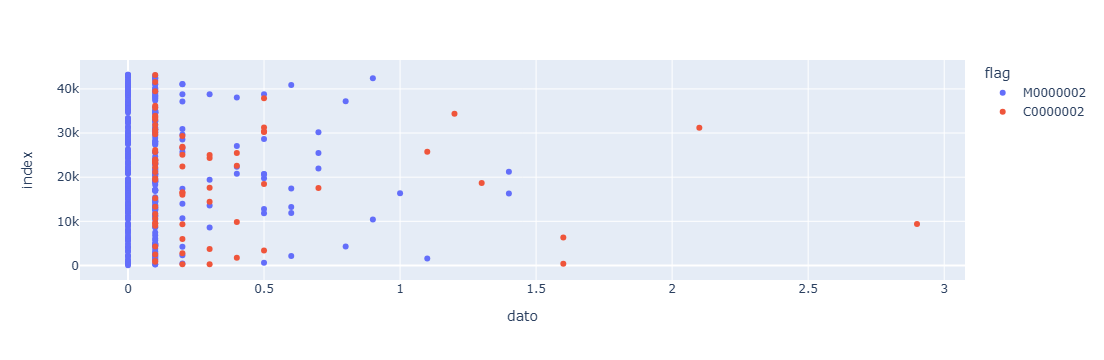

In [51]:
px.scatter(df_temp[df_temp['codigo']=='472F43AC'],x= 'dato', color='flag')

In [22]:
#px.scatter(df_bads_c1, x='dato',y='codigo')

In [23]:
#px.scatter(df_temp.groupby('codigo').max()[['90%']]*10, x='90%')

In [24]:
#df_temp.groupby('codigo').max()[['90%']]

In [25]:
#df_temp[df_temp['90%']<0.1].count()['codigo'] , len(df_temp)

In [26]:
#px.scatter(df_temp.groupby('codigo').mean(), x='umb1')

In [54]:
"""
REGRESION
"""

comentarioCLAS_DUD = 'REGRESION: VFinal - Replica V7 (Var RandomState):  SWAP VAL Y TEST!!'
p_clas_dud = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset      
    'flags'      : ['C0000002'],
    'flagV2'     : ['D01','D02'],
    'estaciones' : [],
    'ceros'      : False,
    'delete'     : True,
    'menor'      : None,
    'mayor'      : None,
    
    # Split    
    'validacion' : 0.15,#0.1,
    'pruebas'    : 0.176 ,#0.11,
    'random_state' : 50, #5 (m0.1)
    'fixed_hour' : '10', # max 23 hour
    'stratify'   : 'flag_m2_group',
    'index'      : 'index_st_group',
    'niv_prec'   : 6,
    'col_prec'   : 'umb1',
    
    # Modelo
    'redTipo'    : 'Regresion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : '',
    'condicion_1': [],
    
    # Nombres
    'nameDS'     : 'ClaseV7_Regresion',       
}

In [52]:
100-15

85

In [53]:
15/85


0.17647058823529413

Tipo de dataset: Regresion
Se leera los archivos de datasets...
Tiempo tomado: 0.00s
+Cantidad de datos leidos 43270

Se elimnara los valores nulos y dudosos
Tiempo tomado: 0.02s
+Cantidad de datos luego de elimnar nulos 43270
-------> CANTIDAD FINAL DE DATOS :  31880 <--------------
Tiempo total: 0.03s
Tamaño de los datasets: 
TRAIN   : 22328 - 70.03764115432874 - C0000002    1.0
Name: flag, dtype: float64
VALID   : 4782 - 15.0 - C0000002    1.0
Name: flag, dtype: float64
PRUEBAS : 4770  - 14.962358845671266 - C0000002    1.0
Name: flag, dtype: float64
           ESTADISCIAS DEL ClaseV7_Regresion 

Flags       : ['C0000002']
Estaciones  : 152
Totales     : 31880
Ceros       : 0
Menor a 1   : 18438
Mayor a 1   : 12479
Maximo      : 66.9
Media       : 1.714586574654956
STD         : 3.239799968338469


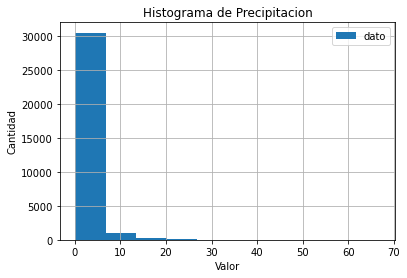

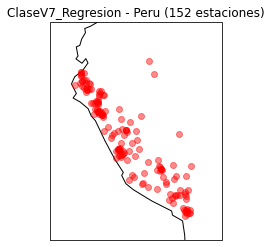

,Unnamed: 0,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,umb1,umb2,fecha,flag,flagV2,imagen
5121,19022,CRUCERO ALTO,47E3903C,701,951,-70.91100,-15.76448,4511.0,0.6,0.0,1.1,0.0,2.2,5.1,2021-03-22-13,C0000002,D02,701--951--2021-03-22-13
33876,1910,CAPACHIQUE,472EB1D2,291,513,-78.31184,-7.85642,2904.0,0.2,0.0,1.2,0.0,5.0,8.7,2021-11-17-05,C0000002,D02,291--513--2021-11-17-05


In [55]:
dfLimpioCLAS_DUD, _dsTrain, _dsValid, _dsTest = getModelo_DS(dsInit, path_imagenes, p_clas_dud ,comentario=comentarioCLAS_DUD, read=False)
dfLimpioCLAS_DUD.head(2)

In [153]:
"""
Clasificacion
"""
comentarioCLAS_DUD = 'VFinal - Replica V7 (Var RandomState):  SWAP VAL Y TEST!!'
p_clas_dud = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset      
    'flags'      : ['C0000002','M0000002'],
    'flagV2'     : ['D01','D02','C01'],
    'estaciones' : [],
    'ceros'      : False,
    'delete'     : True,
    'menor'      : None,
    'mayor'      : None,
    
    # Split    
    'validacion' : 0.1,
    'pruebas'    : 0.11,
    'random_state' : 50, #5 (m0.1)
    'fixed_hour' : '10', # max 23 hour
    'stratify'   : 'flag_m2_group',
    'index'      : 'index_st_group',
    'niv_prec'   : 6,
    'col_prec'   : 'umb1',
    
    # Modelo
    'redTipo'    : 'Clasificacion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : 'clase',
    'condicion_1': ['flag','C0000002'],    
    
    # Nombres
    'nameDS'     : 'ClaseVFinal_M0',       
}

In [20]:
dsInit = pd.read_csv(listDataset[0])

In [154]:
# -TODOO Quitamos C01 con C00000002
dsInit = pd.read_csv(listDataset[0])
dsInit = dsInit[~((dsInit['flag'].isin(['C0000002']))&(dsInit['flagV2'].isin(['C01'])))]

In [155]:
dsInit.groupby(['flag','flagV2']).count()

Unnamed: 0  nombre  codigo     XO     XA  longitud  latitud  \
flag     flagV2                                                                
C0000002 D01          11544   11544   11544  11544  11544     11544    11544   
         D02          20336   20336   20336  20336  20336     20336    20336   
M0000002 C01           2306    2306    2306   2306   2306      2306     2306   
         D01            238     238     238    238    238       238      238   
         D02            258     258     258    258    258       258      258   

                 altura   dato    90%    99%    75%   umb1   umb2  fecha  \
flag     flagV2                                                            
C0000002 D01      11544  11544  11544  11544  11544  11544  11544  11544   
         D02      20336  20336  20336  20336  20336  20336  20336  20336   
M0000002 C01       2306   2306   2306   2306   2306   2306   2306   2306   
         D01        238    238    238    238    238    238    238    238   
         D02        258    258    258    258    258    258    258    258   

                 imagen  
flag     flagV2          
C0000002 D01      11544  
         D02      20336  
M0000002 C01       2306  
         D01        238  
         D02        258

In [150]:
#dsInit[(dsInit['dato']<1)&(dsInit['flag']=='M0000002')].groupby('dato').count()

Tipo de dataset: Clasificacion
Se leera los archivos de datasets...
Tiempo tomado: 0.00s
+Cantidad de datos leidos 34682

Se elimnara los valores nulos y dudosos
Tiempo tomado: 0.02s
+Cantidad de datos luego de elimnar nulos 34682
-------> CANTIDAD FINAL DE DATOS :  32620 <--------------
Tiempo total: 0.04s
Tamaño de los datasets: 
TRAIN   : 26308 - 80.64990803188228 - C0000002    0.976661
M0000002    0.023339
Name: flag, dtype: float64
VALID   : 3211 - 9.843654199877376 - C0000002    0.978823
M0000002    0.021177
Name: flag, dtype: float64
PRUEBAS : 3101  - 9.506437768240342 - C0000002    0.981296
M0000002    0.018704
Name: flag, dtype: float64
           ESTADISCIAS DEL ClaseVFinal_M0 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 153
Totales     : 32620
Ceros       : 0
Clase 0(M02): 2.2685469037400368 - 740
Clase 1(C02): 97.73145309625997 - 31880
Maximo      : 337.5
Media       : 1.9167084610668301
STD         : 8.238564165577053


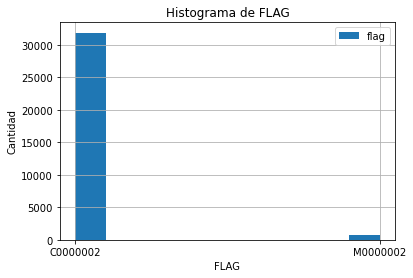

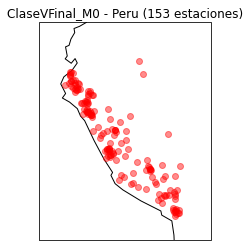

,index,Unnamed: 0,nombre,codigo,XO,XA,longitud,latitud,altura,dato,...,75%,umb1,umb2,fecha,flag,flagV2,imagen,clase,index_st_group,flag_m2_group
0,7211,4993,CACHICOTO,47E845FC,400,586,-76.35028,-9.18361,1109.0,3.6,...,0.0,5.5,28.6,2021-02-16-21,C0000002,D02,400--586--2021-02-16-21,1,47E845FC-0,0
1,33805,7685,CACHICOTO,47E845FC,400,586,-76.35028,-9.18361,1109.0,15.0,...,0.0,5.5,28.6,2021-02-16-22,C0000002,D02,400--586--2021-02-16-22,1,47E845FC-0,0


In [156]:
dfLimpioCLAS_DUD, _dsTrain, _dsValid, _dsTest = getModelo_DS(dsInit, path_imagenes, p_clas_dud ,comentario=comentarioCLAS_DUD, read=False)
dfLimpioCLAS_DUD.head(2)

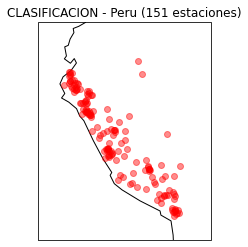

In [18]:
import pandas as pd


visualizarEstaciones(df_temp[~df_temp['codigo'].isin(['47E1F02E','47251282'])], name = 'CLASIFICACION',imagenTest='')

In [16]:
df_temp[~df_temp['codigo'].isin(['47E1F02E','47251282'])]

NameError: name 'codigo' is not defined

           ESTADISCIAS DEL ds 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 151
Totales     : 26308
Ceros       : 0
Clase 0(M02): 2.3338908316861793 - 614
Clase 1(C02): 97.66610916831382 - 25694
Maximo      : 337.5
Media       : 1.8983320662916223
STD         : 8.021763744019845


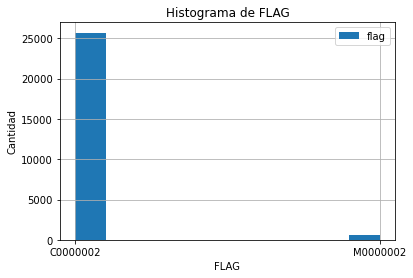

In [157]:
statsDS(_dsTrain, name='ds', tipo='Clasificacion')

           ESTADISCIAS DEL ds 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 130
Totales     : 3211
Ceros       : 0
Clase 0(M02): 2.117720336343818 - 68
Clase 1(C02): 97.88227966365618 - 3143
Maximo      : 310.8
Media       : 1.9396947991279976
STD         : 9.319314711828367


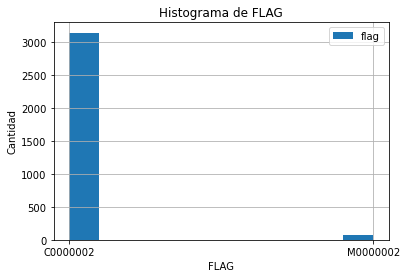

In [158]:
statsDS(_dsValid, name='ds', tipo='Clasificacion')

           ESTADISCIAS DEL ds 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 136
Totales     : 3101
Ceros       : 0
Clase 0(M02): 1.870364398581103 - 58
Clase 1(C02): 98.1296356014189 - 3043
Maximo      : 310.8
Media       : 2.0488068365043537
STD         : 8.841014329948417


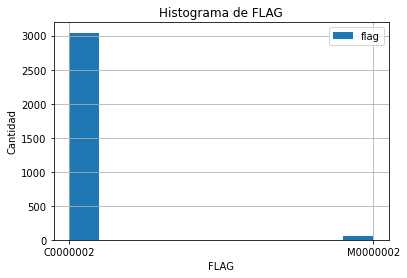

In [159]:
statsDS(_dsTest, name='ds', tipo='Clasificacion')

In [72]:
#px.scatter(_dsTrain, x='dato',y='codigo', color='flag')

In [12]:
df_v7 = pd.read_csv('C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes/Archivos/Dataset/Clasificacion/ClaseV7_CompletoDS.csv')

In [15]:
df_v7['flagV2'].unique()

array(['D02', 'D01'], dtype=object)

           ESTADISCIAS DEL ds_v7 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 146
Totales     : 12623
Ceros       : 0
Clase 0(M02): 1.1407747762021707 - 144
Clase 1(C02): 98.85922522379784 - 12479
Maximo      : 337.5
Media       : 4.3519004990889645
STD         : 12.86890030395137


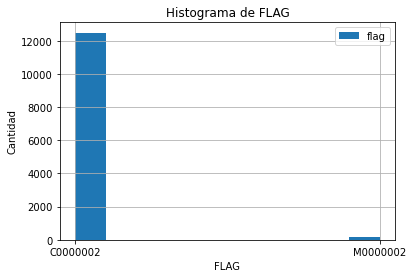

In [16]:
statsDS(df_v7, name='ds_v7', tipo='Clasificacion')

In [18]:
#px.scatter(df_v7, x='dato',y='codigo', color='flag')

In [20]:
#df_v7['dato'].min()

In [23]:
print(df_v7.shape)
print(df_v7.columns)
df_v7.head()

(12623, 19)
Index(['Unnamed: 0.1', 'Unnamed: 0', 'nombre', 'codigo', 'XO', 'XA',
       'longitud', 'latitud', 'altura', 'dato', '90%', '99%', '75%', 'umb1',
       'umb2', 'fecha', 'flag', 'flagV2', 'imagen'],
      dtype='object')


,Unnamed: 0.1,Unnamed: 0,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,umb1,umb2,fecha,flag,flagV2,imagen
0,27871,18494,PUENTE SALINAS AMOJAO,472B55E0,281,379,-78.48940,-5.45096,381.0,4.1,0.1,3.90,0.0,0.5,2.7,2021-11-14-12,C0000002,D02,281--379--2021-11-14-12
1,4969,42999,MALINOWSKY,47E8336C,779,794,-69.51750,-12.93411,215.0,2.0,0.0,8.26,0.0,1.1,10.4,2021-11-27-03,C0000002,D02,779--794--2021-11-27-03
2,2144,8175,SALITRAL EHA,47E067B6,206,373,-79.83761,-5.34602,156.0,1.7,0.0,0.70,0.0,6.0,17.3,2021-12-10-21,C0000002,D02,206--373--2021-12-10-21
3,461,32212,PUENTE AMBAN,47E1E358,257,442,-78.91262,-6.58271,1532.0,2.9,0.0,2.40,0.0,1.9,5.2,2021-10-01-14,C0000002,D02,257--442--2021-10-01-14
4,15683,14721,GUZMANGO,472C81BC,258,486,-78.90330,-7.38133,2464.0,2.4,0.0,1.60,0.0,4.0,11.7,2021-10-20-02,C0000002,D02,258--486--2021-10-20-02
